# Exercício para sala de aula - Autoencoder

### **Introdução e objetivos:**
Este notebook é um material complementar a disciplina de Aprendizado de Máquinas 2. O objetivo é reforçar os conteúdos da aula de autoencoders. Vamos utilizar algumas das técnicas aqui para desenvolver um autoencoder para recnostrução das imagens do Fashion MNIST.

Como observamos em sala, existem várias aplicações que podem ser desenvolvidas a partir dos autoencoders: redução de dimensionalidade, classificação, remoção de ruído e etc.

### **Execução:**
A execução deste notebook será feita através do Colab direto do Google Drive. Não existe impedimento para que este notebook seja executado em outro ambiente desde que os pacotes necessários estejam instalados corretamente.

É recomendável executar este treinamento em um ambiente com GPU. O tamanho da rede aumentou bastante com relação aos exemplo que vimos em sala tornando o tempo de treinamento mais custoso.

### **Exercícios**

**Exercício 1** - Amarre os pesos do encoder com o decoder para tornar o treinamento mais eficiente

**Exercício 2** - Experimente ao menos duas arquiteturas (número de camadas, número de neurônios nas camadas escondidas e número de neurônios na camada de codificação) diferentes para este autoencoder.

**Exercício 3** - Aplique o encoder treinado para treinamento supervisionado.

**Exercício 4** - Avalie a solução final do modelo supervisionado respondendo algumas perguntas

Pacotes necessários

In [2]:
# Reprodutibilidade
import numpy as np
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix


In [3]:
# Treinamento e construção da rede neural
import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.datasets import fashion_mnist
from keras import regularizers, optimizers
from keras import utils
from keras import metrics

# Visualização

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import pandas as pd

seed(1)
tf.random.set_seed(2)


Verificando a execução com aceleração em GPU

In [4]:
!nvidia-smi


Tue Oct  8 23:07:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P3             13W /   30W |     299MiB /   4096MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Exercício 1** - Amarre os pesos do encoder com o decoder para tornar o treinamento mais eficiente

Neste exercício o seu objetivo é amarrar os pesos do *encoder* com o *decoder* com objetivo de tornar o treinamento mais eficiente. Nós vimos este exemplo no notebook da Aula 7 que está disponível no moodle.

In [5]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, kernel_regularizer=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros", regularizer=self.kernel_regularizer)
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

## Tivemos um pequeno ajuste na classe para utilizar o regularizer


## **Exercício 2** - Experimente ao menos duas arquiteturas (número de camadas, número de neurônios nas camadas escondidas e número de neurônios na camada de codificação) diferentes para este autoencoder.

*Uma dica: salve as configurações da rede que vocês estão experimentando ou versionem o notebook. Você irá precisar dessas referências no final do notebook para responder as perguntas do **Exercício 4**.*

In [6]:
tied_encoder = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0002)),
  keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0002)),
  keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0002)),
  keras.layers.Dense(10, activation='softmax'),
])


tied_decoder = keras.models.Sequential([
  keras.layers.Dense(10, activation='relu', input_shape=[10]),
  keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0002)),
  keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0002)),
  keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0002)),
  keras.layers.Dense(28 * 28, activation='sigmoid'),
  keras.layers.Reshape([28, 28])
])


c:\Users\knd\repos\study\POLI\ML2\10.08\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\knd\repos\study\POLI\ML2\10.08\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Instanciando o autoencoder

In [7]:
autoencoder = keras.models.Sequential([tied_encoder, tied_decoder])


adam = optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer=adam, loss='binary_crossentropy', metrics=["accuracy"])


In [8]:
print(autoencoder.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 10)             │       111,146 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28)         │       112,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,176 (871.78 KB)

 Trainable params: 223,176 (871.78 KB)

 Non-trainable params: 0 (0.00 B)

None


Instanciando o encoder

In [9]:
print(tied_encoder.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,146 (434.16 KB)

 Trainable params: 111,146 (434.16 KB)

 Non-trainable params: 0 (0.00 B)

None


Instanciando o decoder

In [10]:
print(tied_decoder.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,030 (437.62 KB)

 Trainable params: 112,030 (437.62 KB)

 Non-trainable params: 0 (0.00 B)

None


Leitura e pré-processamento dos dados

In [11]:
(x_train, y_train), (x_temp, y_temp) = fashion_mnist.load_data()

# Estou separando aqui um conjunto de dados que serão utilizados (x_valid, y_valid) na etapa de treinamento supervisionado.
# Este será o nosso conjunto de dados anotados. No restante das etapas não faremos uso das anotações.
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=0.33)


In [12]:
x_train = x_train.astype('float64') / 255.
x_test = x_test.astype('float64') / 255.
x_valid = x_valid.astype('float64') / 255.
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28)
(6700, 28, 28)


In [13]:

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [14]:
%%time
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=512,
                shuffle=True,
                validation_data=(x_valid, x_valid),
                callbacks=[reduce_lr, early_stopping_cb],
                verbose = 1)


Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0486 - loss: 0.5395 - val_accuracy: 0.0499 - val_loss: 0.4245 - learning_rate: 0.0100
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0535 - loss: 0.4201 - val_accuracy: 0.0675 - val_loss: 0.4039 - learning_rate: 0.0100
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0655 - loss: 0.3939 - val_accuracy: 0.0767 - val_loss: 0.3701 - learning_rate: 0.0100
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0742 - loss: 0.3619 - val_accuracy: 0.0806 - val_loss: 0.3561 - learning_rate: 0.0100
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0833 - loss: 0.3542 - val_accuracy: 0.0884 - val_loss: 0.3513 - learning_rate: 0.0100
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0882 - loss: 0.3500 - val_accuracy: 0.0890 - val_loss: 0.3487 - learning_rate: 0.0100
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0903 - l

In [15]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


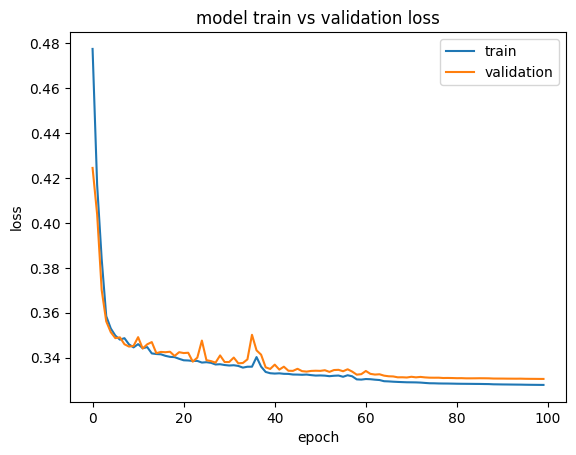

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [17]:
decoded_imgs = autoencoder.predict(x_test)


210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


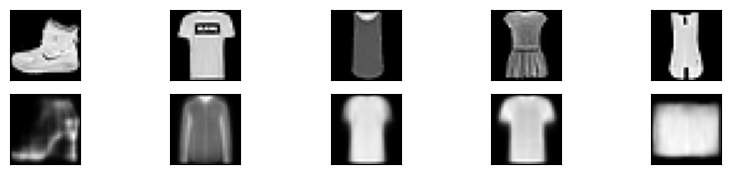

In [18]:
n = 5
plt.figure(figsize=(10, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## **Exercício 3** - Aplique o encoder treinado para treinamento supervisionado.

In [19]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


In [20]:
class_model = Sequential()
class_model.add(tied_encoder)


In [21]:
class_model.compile(loss='categorical_crossentropy',
                   optimizer='adam', metrics=[metrics.AUC(), rounded_accuracy])


In [22]:
class_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 10)             │       111,146 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,146 (434.16 KB)

 Trainable params: 111,146 (434.16 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
y_train_c = to_categorical(y_train, 10)
y_test_c = to_categorical(y_test, 10)
history = class_model.fit(x_train, y_train_c, validation_data=(x_test, y_test_c), epochs=2)


Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8658 - loss: 1.3993 - rounded_accuracy: 0.9294 - val_auc: 0.9774 - val_loss: 0.6525 - val_rounded_accuracy: 0.9585
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9786 - loss: 0.6303 - rounded_accuracy: 0.9593 - val_auc: 0.9824 - val_loss: 0.5601 - val_rounded_accuracy: 0.9638


## **Exercício 4** - Avalie a solução final do modelo supervisionado. Responda ao final as seguintes perguntas:

**Como você analisa a solução final?**


A solução final parece ser eficaz, considerando que o autoencoder foi capaz de reconstruir algumas das imagens do conjunto de teste de forma razoável. A visualização das imagens originais e reconstruídas sugere que o modelo aprendeu a capturar as características principais das imagens. No entanto, a precisão do modelo supervisionado pode ser melhorada, as dificuldades que teve com algumas roupas indica que há espaço para ajustes nos hiperparâmetros ou na arquitetura para melhorar o desempenho.







**Quais ponderações você faz sobre o pipeline utilizado para o desenvolvimento deste modelo?**

O pipeline é bem estruturado, começando com a construção do autoencoder e, em seguida, utilizando o encoder treinado para o modelo supervisionado. Isso é uma boa prática, pois permite que o modelo aproveite as representações aprendidas durante a fase de autoencoder. No entanto, seria interessante explorar mais o ajuste fino dos hiperparâmetros, como a taxa de aprendizado e o número de épocas, além de testar diferentes arquiteturas para o encoder e decoder, conforme sugerido no exercício 2.



**Seria possível utilizar um número de neurônios menor na camada de codificação? Qual o impacto dessa redução?**

Sim, é possível reduzir o número de neurônios na camada de codificação. Isso pode resultar em um modelo mais compacto e eficiente, mas também pode levar a uma perda de informação, o que pode afetar negativamente a capacidade do autoencoder de reconstruir as imagens com precisão. A escolha do número de neurônios deve equilibrar a necessidade de compressão com a preservação de informações essenciais.



**Qual o impacto no modelo de classificação de congelar ou não os pesos?**

Congelar os pesos do encoder durante o treinamento supervisionado pode ajudar a preservar as representações aprendidas durante a fase de autoencoder, especialmente se essas representações forem úteis para a tarefa de classificação. No entanto, não congelar os pesos permite que o modelo ajuste essas representações para melhor se adequar à tarefa de classificação específica, o que pode melhorar o desempenho se o conjunto de dados supervisionado for suficientemente grande e diverso. A decisão de congelar ou não os pesos deve ser baseada em experimentação e análise dos resultados.
